# Assess the detectability of a power-law signal, depending on the errors of the noise PSD

In this simple notebook, we try to define a pipeline to assess detectability of a given stochastic signal based on the techniques described in [this](https://arxiv.org/abs/1906.09027) paper. We go one step further by estimating the parameter spaces that would yield a detectable signal with LISA, given assumptions about the instrument noise.

This notebook uses software than can be found [here](https://github.com/karnesis/spectral).

NK & ML 2021

## Load modules

In [1]:
# Load standard modules
import numpy as np
import matplotlib as mpl
rcparams = {}
rcparams['axes.linewidth'] = 0.5
rcparams['font.family'] = 'serif'
rcparams['font.size'] = 22
rcparams['legend.fontsize'] = 16
rcparams['mathtext.fontset'] = "stix"
mpl.rcParams.update(rcparams) # update plot parameters
import matplotlib.pyplot as plt
import sys, copy, corner, warnings
warnings.filterwarnings("ignore")

# Load LISA instrument noise
from ldc.lisa.noise import get_noise_model

# Load the spectral module found in https://github.com/karnesis/spectral
from spectral import lpsd, psd

# Load a simple MCMC module, found in https://gitlab.in2p3.fr/Nikos/metropolishastings. In fact, any will do.
from mhmcmc import mhsampler

# import local modules
sys.path.append('../code/')
from utils import BFf, posterior_f, ltf_plan, eval_on_grid2D
from models import powerlaw, broken_powerlaw, response

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Here I start playing around
### For now I load my already simulated time series to get an estimate of the PSD errorbars. This is not possible now, so instead I directly simulating the time-series from the noise PSD I that I will load.

In [2]:
dt       = 15.0 # The cadence
TObs_yr  = 3    # The observation time for the above data-set
YRSID_SI = 31558149.763545600
TObs_SI  = TObs_yr*YRSID_SI

Load the settings for the lpsd for each observation time

In [3]:
Nsegs = 156 # For the duration of 3 years, we get very good presicion to 1e-4 Hz with this number of segments

nfft = int(TObs_SI / dt)  # Get the number of samples for the given duration of observation and fs

# One can also use the code below and avoid computing the lpsd explicitly (it's a bit time consuming)
fv, r, m, L, Navs  = ltf_plan(nfft, fs=1/dt, Jdes=200, Kdes=Nsegs, flims = [1e-4, 2e-1])

## Playing with some data-driven simple scenarios

In [4]:
# Some definitions
pc    = 3.08567758149136727e+16
H0    = 67.1
H0_SI = H0 * 1000 / (1e6 * pc)
    
# h**2
h2 = 0.67**2

# A freq vector for ploting 
fvec = np.logspace(-4, np.log10(2e-1), num=1000)

# Choose the noise in TDI (now with the new f-vector)
S_model = copy.deepcopy(get_noise_model('SciRDv1', fvec).psd(fvec, option='A')) 

# Get the response
R = response(fvec)

# Define the Noise in Omega units
SAEhn_0 = S_model/R

OmT = (4 * np.pi**2 * fvec**3 ) / (3 * H0_SI * H0_SI )

# Noise in h**2 Omega units 
Omega_0 = h2 * SAEhn_0 * OmT

# Normalizing constant -> Normalize the data to 1.0 for numerical stability
norm_const = copy.deepcopy(Omega_0)

# Interpolate to make nicer
Naverages = np.interp(fvec, fv, Navs) 

../code/utils.py:179: RuntimeWarning: divide by zero encountered in log
  logpost[:, kk] += np.log(postpdf(S_o_hat[kk]))


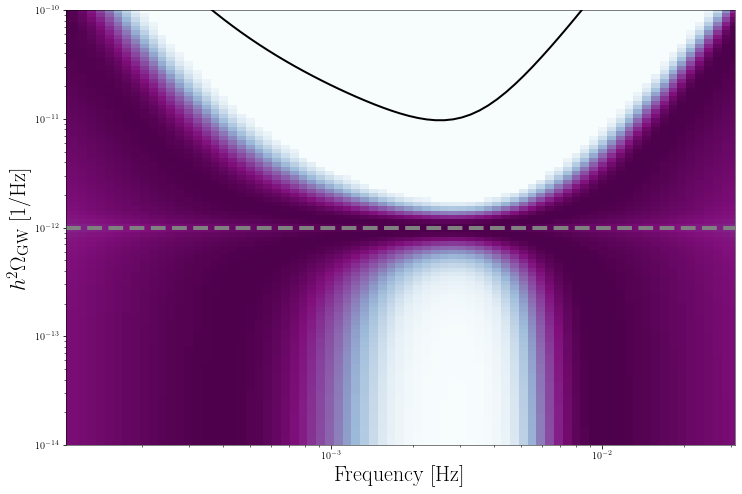

In [5]:
signalmodel = powerlaw(fv, refFreq=2e-3)
s = signalmodel.eval([-12., -0.0])
epsilon = .01

n = np.interp(fv, fvec, Omega_0) 
D = [n + s, n + s]

_,_,_,(fig, ax) = posterior_f(fv, n, Navs, D, D_e=None, epsilon=epsilon, \
                    logylims=[-14, -10], ngrid=100, \
                        Nsigmas=1, v=True, plot=True, \
                            cmap=plt.cm.BuPu, shading='auto')

ax.loglog(fv, s, lw=4, linestyle='--',color='gray')

# Define a criterion to test parameter spaces that yield detectable signals

In [6]:
def criterion(theta, cap=2): 
    """
    The criterion to assess detectability. 

    For cap = 2, we have a logBF = 2 -> BF = 100 which 
    means certain detection.

    """
    signal = signalmodel.eval(theta)
    data   = [ (Omega_0 + signal)/norm_const, (Omega_0 + signal)/norm_const ]
    
    logBF_f = BFf(Omega_0/norm_const, Naverages, data, epsilon, De=None, t=1., ceil=1e1000, v=False)
                        
    # Need to cap infinities.  
    inf_inds = logBF_f==np.inf
    logBF_f[inf_inds] = np.nanmax(logBF_f[logBF_f != np.inf])
    
    detect_inds = logBF_f >= cap

    # If any frequency gives us BF above 100, we say the signal is detectable! 
    detectability = np.zeros_like(logBF_f)
    detectability[detect_inds] = 1
        
    if np.any(detectability):
        return 1
    else:
        return 0


../code/utils.py:108: RuntimeWarning: overflow encountered in true_divide
  BF = Const * (Nom / Denom) # BF
../code/utils.py:122: RuntimeWarning: invalid value encountered in log10
  return np.real(np.log10(BF))
../code/utils.py:303: UserWarning: No contour levels were found within the data range.
  ax.contour(X, Y, g.T, 0, colors=clr, linestyles='-', alpha = 0.9,)


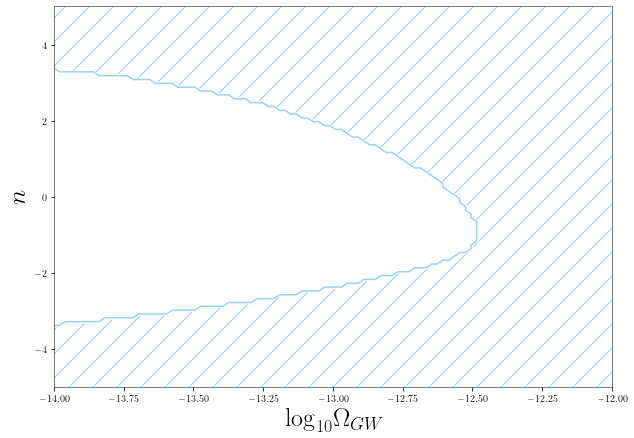

In [7]:
signalmodel = powerlaw(fvec, refFreq=2e-3)
epsilon = .01

amplitude = np.linspace(-14, -12, num=100)
slope     = np.linspace(-5, 5, num=100)

# Evaluate on a grid
eval_on_grid2D([amplitude, slope], criterion, pnames=["$\mathrm{log}_{10}\Omega_{GW}$", "$n$"])

# Same with MCMC

In [8]:
pnames  = ["$\mathrm{log}_{10}A$", "$n_0$"]
inivals = [-12, 0]
cmin = np.array([-16, -5]) # lower range of prior
cmax = np.array([-11, 5])   # upper range of prior. 

def costfun(theta):
    """ Just a silly cost function to explore a parameter space
    """
    lp = 0. if np.all((theta > cmin) & (theta < cmax)) else -np.inf
    if lp == 0.:
        p = criterion(theta)
        if p == 1:
            return 1
        else:
            return -np.inf
    else:
        return -np.inf

# Settting up the MCMC run
pars     = copy.deepcopy(inivals)
CovMat   = 1e-6*np.eye(len(inivals)) # Get an initial covariance matrix
burnin   = 1e4      # Burn-in period. Up to then we optimize the proposal
Nsamples = 1.1e5    # total nubmer of samples
ploTr    = False    # Flag to plot the traces quite often -> monitor progress
DEBUG    = False    # Flag to debug, set verbose level.
fprintf  = 1e5      # The frequency of printing info on screen
cvarupd  = 1e3      # Covariance update frequency (every cvarupd samples)
HT       = 1.0      # Heat parameter of the simulated annealing process.
of       = 'a_test' # Name of output file
pargs    = ()

# Run the mcmc
finalChains, mn, err, C, corr = mhsampler(costfun, pars, pnames, pargs, \
                                            Cvar=CovMat, \
                                            heat=HT, \
                                            TC=[0, 1.0, burnin], \
                                            N=Nsamples, \
                                            CvarUpdate=cvarupd, \
                                            Fprintf=fprintf, \
                                            DOPLOT=ploTr, \
                                            DEBUG=DEBUG, \
                                            outFile=of)


  Starting MH MCMC with config:

   * Starting values: [-12, 0]
   *       Nsamples : 110000
   *             TC : [0, 1.0, 10000.0]



../code/utils.py:108: RuntimeWarning: overflow encountered in true_divide
  BF = Const * (Nom / Denom) # BF
../code/utils.py:122: RuntimeWarning: invalid value encountered in log10
  return np.real(np.log10(BF))


------------- Parameters Update -------------
  Iteration :  100000
  Parameters:  	 \mu =- \sigma
---------------------------------------------
    $\mathrm{log}_{10}A$-12.5 +- 1.1
    $n_0$          0.1 +- 3.3
  Acceptance rate: 0.250
*********************************************


  End of main loop. Preparing outputs.
  Performing diagnostic tests on the chains:
---------------------------------------------
  PSRF: 1.0013568304547815
  Neff: 2115.644721710917
   ESS: 98973.13739341697

 * Saving results to disk under chains/a_test_0.txt. 
------------- Final Result -------------
  Parameters:  	 \mu =- \sigma
---------------------------------------------
    $\mathrm{log}_{10}A$-12.5 +- 1.1
    $n_0$          0.1 +- 3.4
  Total acceptance rate: 0.330
*********************************************



 * END of mhsampler 



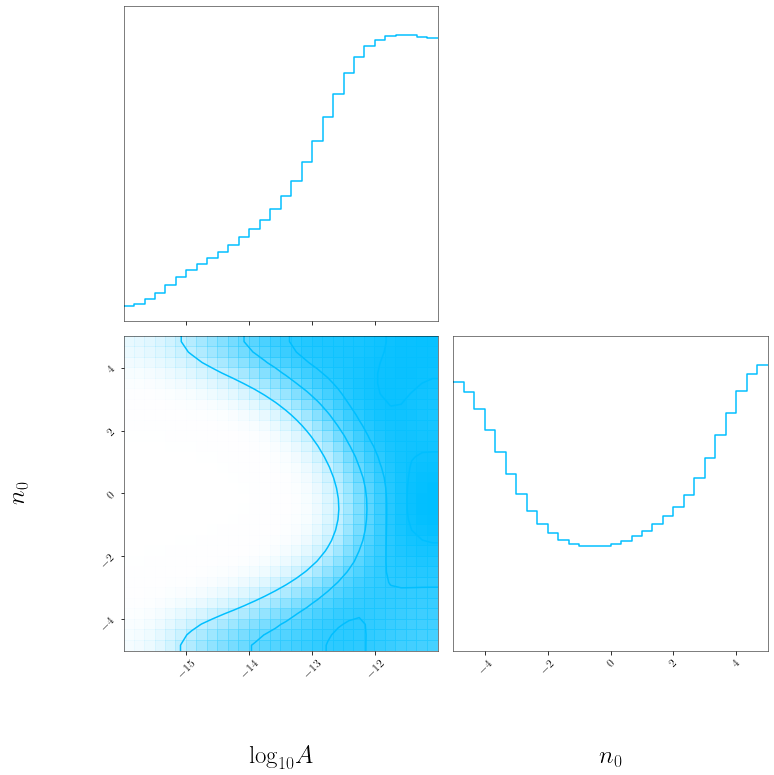

In [12]:
# Corner plot
chains = finalChains[int(burnin):,1:]

rngs = ([cmin[0], cmax[0]], [cmin[1], cmax[1]])

# Do the figures
fig, axes = plt.subplots(2, 2, figsize=(12,12))
fig = corner.corner(chains,labels=pnames, color='deepskyblue', figsize=(20,20),\
                        smooth1d=2, show_titles=False, truth_color='C2', no_fill_contours=True,\
                            title_kwargs={"fontsize": 20}, label_kwargs={"fontsize": 25}, smooth=3, \
                                use_math_text=False, bins=30, ranges=rngs, plot_datapoints=False, fig=fig)

# for control of labelsize of x,y-ticks:
for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)    
    ax.tick_params(axis='both', labelsize=12)
    